# One Class Support Vector Machines

## Importing Libraries

In [47]:
# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Importing tde
import tde

import matplotlib.pyplot as plt

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report #for model performance evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support

# To generate the for loops
import glob
import os
from matplotlib import ticker

## Data Management

In [2]:
# READ INFECTION TIME DATA
infection_data = pd.read_excel('/Users/yoddmena/Downloads/Research/Telemetry_edited/MRSA - Master sheet.xlsx', index_col=0)

# READ AND EXTRACT DATA FROM FOLDER CONTAINING EXCEL SHEETS
folder = "/Users/yoddmena/Downloads/Research/Telemetry_edited/"
files = glob.glob( folder + "Ex *.xlsx" ) 

In [3]:
# CREATE A LIST OF TEMPERATURES
temp = []

for file in files:
    df = pd.read_excel(file)
    file_temp = df.iloc[:, 3::2]  # slicing the data for only temperature
    
    # Ensure that the number of minutes matches the number of temperature columns
    num_temp_columns = file_temp.shape[1]
    
    # Iterate over every other column in file_temp
    for j in range(0, num_temp_columns):
        # Extract the specific temperature column and its corresponding minutes
        column_name = file_temp.columns[j]
        temperature = file_temp[column_name]
        
        # Append the temperature and minutes to each lists
        temp.append(temperature)

## Creating Data Frames

In [4]:
##### INFECTION DATA
infection_data = infection_data.iloc[:,[1,9]]
infection_data = infection_data.T # transpose the data

infection_data.columns = infection_data.iloc[0] # Assign the values of the first row as the new column names

infection_data = infection_data[1:] # Remove the first row (previous column names)


##### TEMPERATURE DATA
df_temp = pd.DataFrame(temp)
df_temp = df_temp.T # transpose the data

df_temp.columns = df_temp.columns.astype(str).str.split(' ').str[0] # Rename columns keeping only the first word


## Scores

In [5]:
# IMPORTING THE SVM MODEL
# this model is from SckiKit Learn
model = svm.OneClassSVM()

# SIGMOID DEFINITION
# we will use the sigmoid function to make our scores be a numerical value that lies between 0 and 1

beta = (2/700) # 700 is the largest value
def sigmoid(scores, beta):
    return 1 / (1 + np.exp(-beta * scores))

In [48]:
#fig,ax = plt.subplots(2,1,figsize=(15,10), sharex = False)
#fig.set_facecolor("white")

train_end = 5760
shift = 2*360 # since the period is 6 hours (360) and we do this twice

# LISTS
# First anomalies after infection
min_scores = []
first_anom_train = []
first_anom_inf = []
score_train = []
score_infec = []
recall_anom = []
precision_anom = []
f1_anom = []
tpr = []

for i in range(0, df_temp.shape[1]): #df_temp.shape[1]
    #ax[0].cla()  # clear axis 0-1
    #ax[1].cla()
    
    #mice_min = range(0, df_temp.shape[0]) # Get the specific minutes for the current temperature time series
    
    temp_value = df_temp.iloc[:, i] # extract the temperature values for the current column
    mice_temp = df_temp.iloc[:, i].to_frame() # converting temp list to data frame
    
    names = mice_temp.columns[0] # get the column name for the current file
    
    ##################################################################
    # Finding Infection Time
    matching_columns = set(mice_temp.columns).intersection(infection_data.columns)
    
    if matching_columns:
        column_name = matching_columns.pop()
        infection_time = infection_data.loc['Aprprox Infection Minute', column_name]
        print(f"Found '{column_name}' and its infection value is '{infection_time}'")
        ##################################################################
        # Filing in missing data
        temp_value_fw = temp_value.fillna(method='ffill') # foward fill
        temp_value_bw = temp_value_fw.fillna(method='bfill') # backward fill after forward fill

        # Time Delay Embedding
        temp_tde = tde.tde(temp_value_bw) # using the tde file
        temp_tde = temp_tde.T # transporting the data

        ##################################################################
        # Fit the Data on the first 3 days (3*24*60) 
        model.fit(temp_tde[:train_end+1,:])

        # Predict the Data
        predict_train_data = model.predict(temp_tde[:train_end+1,:]) # predict on training data
        predict_test_data = model.predict(temp_tde[train_end+1:,:]) # predicting on test data

        # Scores
        scores_train_data = model.score_samples(temp_tde[:train_end+1,:]) # scores on training data 
        scores_test_data = model.score_samples(temp_tde[train_end+1:,:]) # scores on test data

        threshold = model.offset_

        ##################################################################
        # Combine training and testing scores and predictions
        combined_scores= np.concatenate((scores_train_data, scores_test_data), axis=0)
        combined_predictions = np.concatenate((predict_train_data, predict_test_data), axis=0)

        time = np.arange(temp_tde.shape[0])+(shift) # 2 times the time delay shift

        # Minimum score
        min_score = scores_train_data.min()

        # Find the indices of the anomalies
        anomaly_indices = np.where(combined_scores <= min_score)[0] #finding the values where its -1 (anomaly)
        time_2 = anomaly_indices + (shift) # shifting the time for plotting
        
        ##################################################################
        # Find the index at which the first score is less than min_score
        boolean = combined_scores < min_score
        anom_train = np.argmax(boolean) # first anomaly after training period
        anom_infec = np.argmax(boolean[infection_time-shift:]) + infection_time # first anomaly after infection period

        
        # Set up for classification report
        dataset_len_train = len(combined_scores)+shift-train_end # finding the length of the testing dataset
        train_to_inf = combined_scores[train_end-shift : infection_time-shift]
        post_inf = combined_scores[infection_time-shift : ]
        true_neg = np.zeros(len(train_to_inf))
        true_pos = np.ones(len(post_inf))
        y_true = np.append(true_neg, true_pos, axis=0)  # Appends along row
        
        #y_true = np.ones(dataset_len_train) # creating an array of zeroes of that length
        ones_and_zeros_array = boolean.astype(int) # turning boolean outcomes into ones and zeros
        y_pred = ones_and_zeros_array[train_end-shift: ]
        target_names = ['Nonanomalies', 'Anomalies']
        print(classification_report(y_true, y_pred, target_names=target_names, output_dict=True))
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        f1_score = precision_recall_fscore_support(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels = [0,1])
        
        
        # Get the corresponding value
        value = combined_scores[anom_train]
        value_1 = combined_scores[anom_infec-shift]

        # Calculating the time first anomaly was found after training and infection
        time_aft_train = (anom_train + shift) - train_end
        time_aft_infection = anom_infec - infection_time

        # Calculating the amount of false negatives (between end of train and infection time)
        #count_false_neg = np.count_nonzero(boolean[train_end:infection_time])
        count_false_neg = np.count_nonzero(ones_and_zeros_array[infection_time-shift : ] == 0)
        
        # Calculating the amount of true positives (infection time)
        #count_true_pos = np.count_nonzero(boolean[infection_time:]) 
        count_true_pos = np.count_nonzero(ones_and_zeros_array[infection_time-shift : ] == 1)
        
        # Calculating true positive rate
        # Check if the denominator is zero
        if (count_true_pos + count_false_neg) == 0:
            print("N/A")
            continue  # Skip this iteration and move to the next number
        
        TPR = count_true_pos / (count_true_pos + count_false_neg)
        
       
        
        ##################################################################
        '''
        # Plotting 2nd Graph
        ax[1].plot(time, combined_scores, '-', color='#6693F5', alpha=0.75)  # Plot the scores with blue color #[:100]
        ax[1].plot(time_2, combined_scores[anomaly_indices], '', color='purple') #coloring anomalies
        ax[1].grid()
        ax[1].set_ylabel("Score", fontsize=14)
        ax[1].set_xlabel("Minutes", fontsize=14)
        ax[1].set_title(f"Anomalies found using our threshold for '{names}'", fontsize=14)
        #ax[1].set_xlim(infection_time-5,infection_time+30)
        ax[1].set_xlim(-10,26000)
        ax[1].set_ylim(0,700)

        ##################################################################
        # Plotting Horizontal and Vertical Lines
        ax[1].axvline(x = anom_train+shift, color='blue', linestyle='--', label='First anomaly after training') # when the first value is less the minimum value
        ax[1].axvline(x = train_end, color='green', linestyle='-', label='End of training data')
        ax[1].axhline(y=min_score, color='red', linestyle='-', label='Threshold')
        ax[1].axvline(x = anom_infec, color='orange', linestyle ='-', label='First anomaly after infection')
        #ax[1].axhline(y=value, color='blue', linestyle='--', label='value')
        #ax[1].axhline(y=value_1, color='orange', linestyle='-', label='value_1')
        ax[1].legend()

        ##################################################################
        # Print Values
        print("Minimum Score: ", min_score)
        print("After Training Min: ", anom_train+shift)
        print("After Infection Min: ", anom_infec)
        print(f"First anomaly found after training: {time_aft_train} minutes with score {value}")
        print(f"First anomaly found after infection: {time_aft_infection} minutes with score {value_1}")
        print(f"True Positve Rate: {TPR*100}%")
        
        '''

        ##################################################################
        # Appending to Lists
        min_scores.append(min_score)
        first_anom_train.append(time_aft_train)
        first_anom_inf.append(time_aft_infection)
        score_train.append(value)
        score_infec.append(value_1)
        recall_anom.append(recall)
        precision_anom.append(precision)
        f1_anom.append(f1_score)
        tpr.append(TPR)
    
    else:
        print(f"No match found for mouse '{names}'")
    
    print("====================================")
   

Found 'CC006-315' and its infection value is '10300'
{'Nonanomalies': {'precision': 0.7625125965737319, 'recall': 1.0, 'f1-score': 0.8652563369544503, 'support': 4540}, 'Anomalies': {'precision': 1.0, 'recall': 0.9012845573862049, 'f1-score': 0.9480796063743849, 'support': 14324}, 'accuracy': 0.9250424088210347, 'macro avg': {'precision': 0.8812562982868659, 'recall': 0.9506422786931025, 'f1-score': 0.9066679716644176, 'support': 18864}, 'weighted avg': {'precision': 0.9428438925172149, 'recall': 0.9250424088210347, 'f1-score': 0.9281465252056771, 'support': 18864}}
Found 'CC006-316' and its infection value is '10300'
{'Nonanomalies': {'precision': 0.7715311004784688, 'recall': 0.9944933920704846, 'f1-score': 0.8689376443418013, 'support': 4540}, 'Anomalies': {'precision': 0.9980786965877652, 'recall': 0.906660150795867, 'f1-score': 0.9501755926251098, 'support': 14324}, 'accuracy': 0.9277989821882952, 'macro avg': {'precision': 0.884804898533117, 'recall': 0.9505767714331759, 'f1-scor

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.24067005937234945, 'recall': 1.0, 'f1-score': 0.38796786874038625, 'support': 4540}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14324}, 'accuracy': 0.24067005937234945, 'macro avg': {'precision': 0.12033502968617472, 'recall': 0.5, 'f1-score': 0.19398393437019312, 'support': 18864}, 'weighted avg': {'precision': 0.05792207747829021, 'recall': 0.24067005937234945, 'f1-score': 0.09337225000431264, 'support': 18864}}
Found 'CC043-456' and its infection value is '10300'
{'Nonanomalies': {'precision': 0.2940460081190798, 'recall': 0.9572687224669604, 'f1-score': 0.44989648033126295, 'support': 4540}, 'Anomalies': {'precision': 0.9524975514201763, 'recall': 0.2715721865400726, 'f1-score': 0.42264232942199037, 'support': 14324}, 'accuracy': 0.43659881255301103, 'macro avg': {'precision': 0.6232717797696281, 'recall': 0.6144204545035165, 'f1-score': 0.4362694048766267, 'support': 18864}, 'weighted avg': {'precision': 0.7940279794

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.24067005937234945, 'recall': 1.0, 'f1-score': 0.38796786874038625, 'support': 4540}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14324}, 'accuracy': 0.24067005937234945, 'macro avg': {'precision': 0.12033502968617472, 'recall': 0.5, 'f1-score': 0.19398393437019312, 'support': 18864}, 'weighted avg': {'precision': 0.05792207747829021, 'recall': 0.24067005937234945, 'f1-score': 0.09337225000431264, 'support': 18864}}
Found 'CC051-489' and its infection value is '10300'
{'Nonanomalies': {'precision': 0.24679278103935637, 'recall': 1.0, 'f1-score': 0.39588419951168463, 'support': 4540}, 'Anomalies': {'precision': 1.0, 'recall': 0.03267243786651773, 'f1-score': 0.06327744726879395, 'support': 14324}, 'accuracy': 0.26547921967769295, 'macro avg': {'precision': 0.6233963905196782, 'recall': 0.5163362189332589, 'f1-score': 0.22958082339023927, 'support': 18864}, 'weighted avg': {'precision': 0.8187255738930598, 'recall': 0.2654792

{'Nonanomalies': {'precision': 0.3081303563373929, 'recall': 0.9954462659380692, 'f1-score': 0.4705933006113837, 'support': 5490}, 'Anomalies': {'precision': 0.9778368794326241, 'recall': 0.08247345595932407, 'f1-score': 0.15211694938629156, 'support': 13374}, 'accuracy': 0.34817642069550464, 'macro avg': {'precision': 0.6429836178850085, 'recall': 0.5389598609486966, 'f1-score': 0.31135512499883766, 'support': 18864}, 'weighted avg': {'precision': 0.7829318321577715, 'recall': 0.34817642069550464, 'f1-score': 0.2448032920615331, 'support': 18864}}
Found 'CC013-643' and its infection value is '11250'
{'Nonanomalies': {'precision': 0.2920269544993738, 'recall': 0.8919854280510018, 'f1-score': 0.440001797025922, 'support': 5490}, 'Anomalies': {'precision': 0.716945107398568, 'recall': 0.1123074622401675, 'f1-score': 0.1941948412954942, 'support': 13374}, 'accuracy': 0.3392175572519084, 'macro avg': {'precision': 0.5044860309489709, 'recall': 0.5021464451455846, 'f1-score': 0.317098319160

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.238019508057676, 'recall': 1.0, 'f1-score': 0.3845165710370815, 'support': 4490}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14374}, 'accuracy': 0.238019508057676, 'macro avg': {'precision': 0.119009754028838, 'recall': 0.5, 'f1-score': 0.19225828551854074, 'support': 18864}, 'weighted avg': {'precision': 0.05665328621601809, 'recall': 0.238019508057676, 'f1-score': 0.09152244507827056, 'support': 18864}}
Found 'CC003-225' and its infection value is '10250'
{'Nonanomalies': {'precision': 0.3017878747143433, 'recall': 1.0, 'f1-score': 0.4636513837257332, 'support': 4490}, 'Anomalies': {'precision': 1.0, 'recall': 0.27730624739112286, 'f1-score': 0.4342047930283224, 'support': 14374}, 'accuracy': 0.4493214588634436, 'macro avg': {'precision': 0.6508939373571716, 'recall': 0.6386531236955615, 'f1-score': 0.4489280883770278, 'support': 18864}, 'weighted avg': {'precision': 0.8338118934196036, 'recall': 0.4493214588634436, 'f1

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.238019508057676, 'recall': 1.0, 'f1-score': 0.3845165710370815, 'support': 4490}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14374}, 'accuracy': 0.238019508057676, 'macro avg': {'precision': 0.119009754028838, 'recall': 0.5, 'f1-score': 0.19225828551854074, 'support': 18864}, 'weighted avg': {'precision': 0.05665328621601809, 'recall': 0.238019508057676, 'f1-score': 0.09152244507827056, 'support': 18864}}
Found 'CC036-299' and its infection value is '10250'
{'Nonanomalies': {'precision': 0.5813253012048193, 'recall': 0.9456570155902004, 'f1-score': 0.7200271324402239, 'support': 4490}, 'Anomalies': {'precision': 0.9788927335640139, 'recall': 0.7872547655489077, 'f1-score': 0.8726767949410041, 'support': 14374}, 'accuracy': 0.8249575911789653, 'macro avg': {'precision': 0.7801090173844165, 'recall': 0.8664558905695541, 'f1-score': 0.796351963690614, 'support': 18864}, 'weighted avg': {'precision': 0.884263928894125, 'recal

{'Nonanomalies': {'precision': 0.5194520547945205, 'recall': 1.0, 'f1-score': 0.6837360259646592, 'support': 4740}, 'Anomalies': {'precision': 1.0, 'recall': 0.6895355423392806, 'f1-score': 0.8162427188534551, 'support': 14124}, 'accuracy': 0.7675466497031382, 'macro avg': {'precision': 0.7597260273972603, 'recall': 0.8447677711696403, 'f1-score': 0.7499893724090572, 'support': 18864}, 'weighted avg': {'precision': 0.8792516295444247, 'recall': 0.7675466497031382, 'f1-score': 0.7829474620525172, 'support': 18864}}
Found 'CC017-413' and its infection value is '10500'
{'Nonanomalies': {'precision': 0.25133888329179704, 'recall': 1.0, 'f1-score': 0.4017119369464808, 'support': 4740}, 'Anomalies': {'precision': 1.0, 'recall': 0.00035400736335315777, 'f1-score': 0.0007077641729775639, 'support': 14124}, 'accuracy': 0.2515373197625106, 'macro avg': {'precision': 0.6256694416458985, 'recall': 0.5001770036816766, 'f1-score': 0.20120985055972918, 'support': 18864}, 'weighted avg': {'precision':

{'Nonanomalies': {'precision': 0.6518658478979689, 'recall': 0.9963898916967509, 'f1-score': 0.7881210736721873, 'support': 5540}, 'Anomalies': {'precision': 0.9980761831473643, 'recall': 0.7787451215851096, 'f1-score': 0.8748735244519393, 'support': 13324}, 'accuracy': 0.8426632739609838, 'macro avg': {'precision': 0.8249710155226666, 'recall': 0.8875675066409302, 'f1-score': 0.8314972990620633, 'support': 18864}, 'weighted avg': {'precision': 0.8964007560225948, 'recall': 0.8426632739609838, 'f1-score': 0.8493959705227713, 'support': 18864}}
Found 'CC015-439' and its infection value is '11300'
{'Nonanomalies': {'precision': 0.6877406533349895, 'recall': 0.9994584837545126, 'f1-score': 0.8148039143550879, 'support': 5540}, 'Anomalies': {'precision': 0.999722556182373, 'recall': 0.811317922545782, 'f1-score': 0.8957202634958776, 'support': 13324}, 'accuracy': 0.8665712468193384, 'macro avg': {'precision': 0.8437316047586813, 'recall': 0.9053882031501473, 'f1-score': 0.8552620889254827,

{'Nonanomalies': {'precision': 0.3040988387507291, 'recall': 0.9991289198606271, 'f1-score': 0.466279117037278, 'support': 5740}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13124}, 'accuracy': 0.30401823579304493, 'macro avg': {'precision': 0.15204941937536454, 'recall': 0.49956445993031356, 'f1-score': 0.233139558518639, 'support': 18864}, 'weighted avg': {'precision': 0.09253219542139446, 'recall': 0.30401823579304493, 'f1-score': 0.14188094422147876, 'support': 18864}}
Found 'CC053-427' and its infection value is '11500'
{'Nonanomalies': {'precision': 0.6321070234113713, 'recall': 0.9878048780487805, 'f1-score': 0.7709041468388851, 'support': 5740}, 'Anomalies': {'precision': 0.9929250050535678, 'recall': 0.7485522706491923, 'f1-score': 0.853592840385785, 'support': 13124}, 'accuracy': 0.8213528413910093, 'macro avg': {'precision': 0.8125160142324696, 'recall': 0.8681785743489864, 'f1-score': 0.8122484936123351, 'support': 18864}, 'weighted avg': {'pr

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.4527141645462256, 'recall': 1.0, 'f1-score': 0.6232666763976061, 'support': 8540}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10324}, 'accuracy': 0.4527141645462256, 'macro avg': {'precision': 0.2263570822731128, 'recall': 0.5, 'f1-score': 0.31163333819880307, 'support': 18864}, 'weighted avg': {'precision': 0.20495011478078703, 'recall': 0.4527141645462256, 'f1-score': 0.282161652694845, 'support': 18864}}
Found 'CC005-410' and its infection value is '14300'


/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.4527141645462256, 'recall': 1.0, 'f1-score': 0.6232666763976061, 'support': 8540}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10324}, 'accuracy': 0.4527141645462256, 'macro avg': {'precision': 0.2263570822731128, 'recall': 0.5, 'f1-score': 0.31163333819880307, 'support': 18864}, 'weighted avg': {'precision': 0.20495011478078703, 'recall': 0.4527141645462256, 'f1-score': 0.282161652694845, 'support': 18864}}
Found 'CC005-411' and its infection value is '14300'
{'Nonanomalies': {'precision': 0.457369323050557, 'recall': 1.0, 'f1-score': 0.6276642657651037, 'support': 8540}, 'Anomalies': {'precision': 1.0, 'recall': 0.018597442851607904, 'f1-score': 0.03651578546976037, 'support': 10324}, 'accuracy': 0.4628922815945717, 'macro avg': {'precision': 0.7286846615252784, 'recall': 0.5092987214258039, 'f1-score': 0.33209002561743206, 'support': 18864}, 'weighted avg': {'precision': 0.75434340642768, 'recall': 0.4628922815945717, '

{'Nonanomalies': {'precision': 0.2496237248453091, 'recall': 0.9973273942093541, 'f1-score': 0.3993044718890722, 'support': 4490}, 'Anomalies': {'precision': 0.987027027027027, 'recall': 0.06351746208431891, 'f1-score': 0.11935420615726518, 'support': 14374}, 'accuracy': 0.2857824427480916, 'macro avg': {'precision': 0.6183253759361681, 'recall': 0.5304224281468365, 'f1-score': 0.2593293390231687, 'support': 18864}, 'weighted avg': {'precision': 0.8115106558016288, 'recall': 0.2857824427480916, 'f1-score': 0.18598783068736557, 'support': 18864}}
Found 'CC012-1349' and its infection value is '10250'
{'Nonanomalies': {'precision': 0.2512373453318335, 'recall': 0.9948775055679288, 'f1-score': 0.4011674898967221, 'support': 4490}, 'Anomalies': {'precision': 0.9787822878228782, 'recall': 0.07381383052734103, 'f1-score': 0.13727519730883686, 'support': 14374}, 'accuracy': 0.29304495335029684, 'macro avg': {'precision': 0.6150098165773559, 'recall': 0.5343456680476348, 'f1-score': 0.269221343

{'Nonanomalies': {'precision': 0.23174464363795366, 'recall': 1.0, 'f1-score': 0.3762868299609514, 'support': 4240}, 'Anomalies': {'precision': 1.0, 'recall': 0.038840262582056896, 'f1-score': 0.07477619799894682, 'support': 14624}, 'accuracy': 0.2548770144189991, 'macro avg': {'precision': 0.6158723218189768, 'recall': 0.5194201312910285, 'f1-score': 0.2255315139799491, 'support': 18864}, 'weighted avg': {'precision': 0.8273217392400829, 'recall': 0.2548770144189991, 'f1-score': 0.1425457632830276, 'support': 18864}}
Found 'C57Bl6-106' and its infection value is '10000'
{'Nonanomalies': {'precision': 0.2298610729778705, 'recall': 0.9872641509433963, 'f1-score': 0.37290098436595254, 'support': 4240}, 'Anomalies': {'precision': 0.9173047473200613, 'recall': 0.04096006564551422, 'f1-score': 0.0784185376710087, 'support': 14624}, 'accuracy': 0.25365776081424934, 'macro avg': {'precision': 0.5735829101489659, 'recall': 0.5141121082944552, 'f1-score': 0.22565976101848062, 'support': 18864},

{'Nonanomalies': {'precision': 0.25133888329179704, 'recall': 1.0, 'f1-score': 0.4017119369464808, 'support': 4740}, 'Anomalies': {'precision': 1.0, 'recall': 0.00035400736335315777, 'f1-score': 0.0007077641729775639, 'support': 14124}, 'accuracy': 0.2515373197625106, 'macro avg': {'precision': 0.6256694416458985, 'recall': 0.5001770036816766, 'f1-score': 0.20120985055972918, 'support': 18864}, 'weighted avg': {'precision': 0.8118822257635241, 'recall': 0.2515373197625106, 'f1-score': 0.10146899079227385, 'support': 18864}}
Found 'CC017-426' and its infection value is '10500'


/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.25127226463104324, 'recall': 1.0, 'f1-score': 0.4016268429079817, 'support': 4740}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14124}, 'accuracy': 0.25127226463104324, 'macro avg': {'precision': 0.12563613231552162, 'recall': 0.5, 'f1-score': 0.20081342145399084, 'support': 18864}, 'weighted avg': {'precision': 0.06313775097281303, 'recall': 0.25127226463104324, 'f1-score': 0.10091768635410481, 'support': 18864}}
Found 'CC036-290' and its infection value is '10500'
{'Nonanomalies': {'precision': 0.2530429212043562, 'recall': 1.0, 'f1-score': 0.40388548057259716, 'support': 4740}, 'Anomalies': {'precision': 1.0, 'recall': 0.009345794392523364, 'f1-score': 0.018518518518518517, 'support': 14124}, 'accuracy': 0.2582697201017812, 'macro avg': {'precision': 0.6265214606021781, 'recall': 0.5046728971962616, 'f1-score': 0.21120199954555785, 'support': 18864}, 'weighted avg': {'precision': 0.81231040322883, 'recall': 0.2582697201

{'Nonanomalies': {'precision': 0.23012463537523203, 'recall': 0.9997695852534563, 'f1-score': 0.3741323561112309, 'support': 4340}, 'Anomalies': {'precision': 0.8888888888888888, 'recall': 0.000550812448361333, 'f1-score': 0.0011009426821716095, 'support': 14524}, 'accuracy': 0.23043893129770993, 'macro avg': {'precision': 0.5595067621320604, 'recall': 0.5001601988509088, 'f1-score': 0.18761664939670125, 'support': 18864}, 'weighted avg': {'precision': 0.7373284107162176, 'recall': 0.23043893129770993, 'f1-score': 0.0869234794867792, 'support': 18864}}
No match found for mouse 'CC043-563'
Found 'CC043-564' and its infection value is '10100'
{'Nonanomalies': {'precision': 0.22978204380336215, 'recall': 0.9983870967741936, 'f1-score': 0.3735827908781308, 'support': 4340}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14524}, 'accuracy': 0.22969677692960136, 'macro avg': {'precision': 0.11489102190168107, 'recall': 0.4991935483870968, 'f1-score': 0.18679139543

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.23006785411365563, 'recall': 1.0, 'f1-score': 0.3740734356145492, 'support': 4340}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14524}, 'accuracy': 0.23006785411365563, 'macro avg': {'precision': 0.11503392705682781, 'recall': 0.5, 'f1-score': 0.1870367178072746, 'support': 18864}, 'weighted avg': {'precision': 0.05293121749646233, 'recall': 0.23006785411365563, 'f1-score': 0.08606227261276206, 'support': 18864}}
Found 'CC057-705' and its infection value is '10100'
{'Nonanomalies': {'precision': 0.23030981709593132, 'recall': 0.9951612903225806, 'f1-score': 0.374052743255532, 'support': 4340}, 'Anomalies': {'precision': 0.8108108108108109, 'recall': 0.006196640044064996, 'f1-score': 0.012299282541851727, 'support': 14524}, 'accuracy': 0.233725614927905, 'macro avg': {'precision': 0.5205603139533711, 'recall': 0.5006789651833228, 'f1-score': 0.19317601289869188, 'support': 18864}, 'weighted avg': {'precision': 0.67725619287

{'Nonanomalies': {'precision': 0.23541322534235626, 'recall': 0.9950450450450451, 'f1-score': 0.38074718834834315, 'support': 4440}, 'Anomalies': {'precision': 0.7731958762886598, 'recall': 0.005199667221297837, 'f1-score': 0.010329867089043453, 'support': 14424}, 'accuracy': 0.2381785411365564, 'macro avg': {'precision': 0.5043045508155081, 'recall': 0.5001223561331715, 'f1-score': 0.1955385277186933, 'support': 18864}, 'weighted avg': {'precision': 0.6466185347809421, 'recall': 0.2381785411365564, 'f1-score': 0.09751460555338244, 'support': 18864}}
Found 'CC041-1760' and its infection value is '10200'
{'Nonanomalies': {'precision': 0.23761315549841985, 'recall': 0.9990990990990991, 'f1-score': 0.38391968497122336, 'support': 4440}, 'Anomalies': {'precision': 0.9794871794871794, 'recall': 0.013241819190238492, 'f1-score': 0.026130378274847803, 'support': 14424}, 'accuracy': 0.24528201865988125, 'macro avg': {'precision': 0.6085501674927997, 'recall': 0.5061704591446688, 'f1-score': 0.

In [9]:
# Make all lists into arrays
ms = np.array(min_scores)
st = np.array(score_train)
si = np.array(score_infec)

fat = np.array(first_anom_train)
fai = np.array(first_anom_inf)

ra = np.array(recall_anom)
#tprs = np.array(tpr)

In [34]:
# Create the data for the table (calculates statistics)
data1 = {
    'column_1': [round(np.mean(ms),2),round(np.mean(st),2), round(np.mean(si),2)], 
    'column_2': [round(np.std(ms),2), round(np.std(st),2), round(np.std(si),2)],
    'column_3': [round(np.percentile(ms, 25),2), round(np.percentile(st, 25),2), round(np.percentile(si, 25),2)], 
    'column_4': [round(np.percentile(ms, 50),2), round(np.percentile(st, 50),2), round(np.percentile(si, 50),2)], 
    'column_5': [round(np.percentile(ms, 75),2), round(np.percentile(st, 75),2), round(np.percentile(si, 75),2)]
}
                 
data2 = {'column 1':[round(np.mean(fat),2), round(np.mean(fai),2)], 
         'column 2':[round(np.std(fat),2), round(np.std(fai),2)],
         'column 3':[round(np.percentile(fat, 25),2), round(np.percentile(fai, 25),2)],
         'column 4':[round(np.percentile(fat, 50),2), round(np.percentile(fai, 50),2)], 
         'column 5':[round(np.percentile(fat, 75),2), round(np.percentile(fai, 75),2)]
}

data3= {'row 1': [round(np.mean(ra)*100,2), 
                     round(np.std(ra)*100,2), 
                     round(np.percentile(ra, 25)*100,2), 
                     round(np.percentile(ra, 50)*100,2), 
                     round(np.percentile(ra, 75)*100,2)]
}
                     


In [35]:
# Create a DataFrame
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)

# Set row names (index)
row_names1 = ['Minimum Score', 'First Anomaly Score Post-Training', 'First Anomaly Score Post-Infection  ']
df.index1 = row_names1

row_names2 = ['First Anomaly Time Post-Training', 'First Anomaly Time Post-Infection']
df.index2 = row_names2

row_names3 = ['Precision']
df.index3 = row_names3

# Set column names
column_names1 = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns1 = column_names1

column_names2 = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns2 = column_names2

column_names3 = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns3 = column_names3


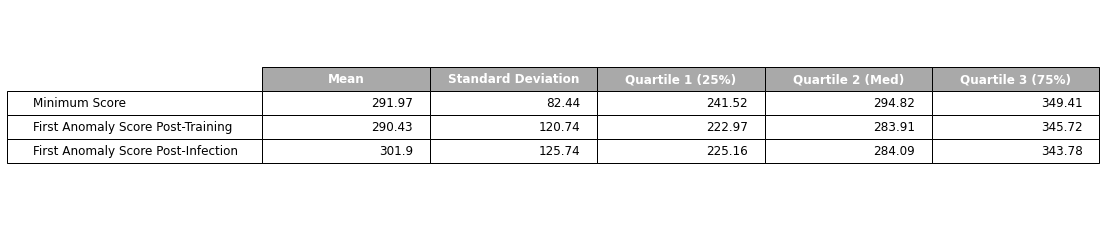

In [36]:
# Saving the Table
# Create a table visualization using matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table1 = ax.table(cellText=df1.values, colLabels=df.columns1, rowLabels=df.index1, loc='center')
table1.auto_set_font_size(True)
table1.set_fontsize(14)
table1.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns1):
    cell = table1[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')
    
# Save the table as an image file
#plt.savefig('table_statistics_4days.png', bbox_inches='tight', facecolor='white')


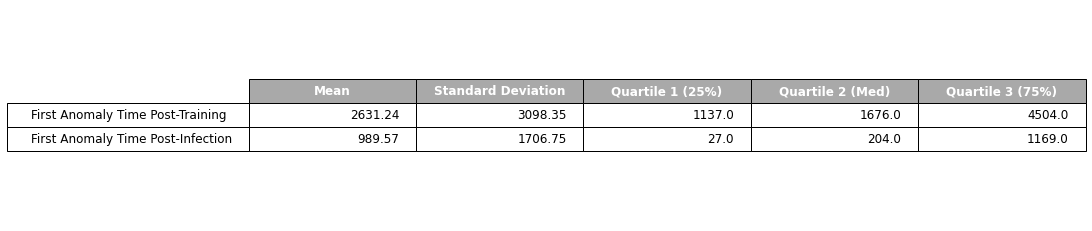

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table2 = ax.table(cellText=df2.values, colLabels=df.columns2, rowLabels=df.index2, loc='center')
table2.auto_set_font_size(True)
table2.set_fontsize(14)
table2.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns2):
    cell = table2[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')

In [ ]:
# Saving the Table
# Create a table visualization using matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table3 = ax.table(cellText=df3.values, colLabels=df.columns3, rowLabels=df.index3, loc='center')
table3.auto_set_font_size(True)
table3.set_fontsize(14)
table3.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns3):
    cell = table3[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')

In [40]:
print("Mean: ", round(np.mean(ra)*100,2))
print("SD: ", round(np.std(ra)*100,2))
print("Q1: ", round(np.percentile(ra, 25)*100,2)) 
print("Q2: ", round(np.percentile(ra, 50)*100,2)) 
print("Q3: ", round(np.percentile(ra, 75)*100,2))

Mean:  22.54
SD:  30.15
Q1:  0.5
Q2:  6.6
Q3:  39.75


In [41]:
len(recall_anom)

153

In [44]:
fai.min()

0

In [46]:
fai.max()

9355